In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets#  HBox, VBox, IntSlider, Play, jslink, Layout, Label
import seaborn as sns
from IPython import display  # used for clearing plots, to view during the simulation
import time
import pickle
import gzip
# for calculating social interactions
import functions.PTWsimulation as ptw
import functions.modelfunctions as mf
 
snscolors=sns.color_palette()

# Run single simulation

### Define parameters and simulation setup

In [20]:
# define parameters
numparticles=2
numsteps = 1 * 10**5


model = mf.simmodel(numparticles,numsteps,)  
model.dt = 0.1
model.savestep=5  # save the results this many steps
model.numsavesteps = np.floor(model.numsimsteps/model.savestep).astype(int) 
model.socialweight = [0.5,0.5]
model.sigma_turn = 3*np.ones(numparticles)  # note that this should be sigma/sqrt(tau_turn)
model.sigma_speed = 0.2  # this should be sigma_speed/sqrt(tau_speed)
model.mu_s = [1.2,0.8]  # the mean should be 1


# ---

model.ignoresteps=[0,5*10**3]

# stop-go added
model.stopgosim=True
# model.Tswitch = np.array([[10,10],[40,10]])
model.statespeedmult = np.array([np.ones(numparticles),0.2/np.array(model.mu_s)]).T  # [individual,states]   # speed multipliers for the states, to modify mu
model.stopgosocial = 0.8




# simulator can be:  ['ptw','classiczonal','persistantzonal']
whichsim = 'ptw'

# vars(model)

In [21]:
# run simulation
start = time.time()
allparticles = ptw.ptwsimulation(model,showprogress=True,simulator=whichsim)
# get metrices for analyzing results
alldist, alldcoords_rotated = ptw.dist_and_dcoords(allparticles,model)

time.time()-start

98000 100000


26.67783546447754

# Plots of results, and Interact for simulated movement

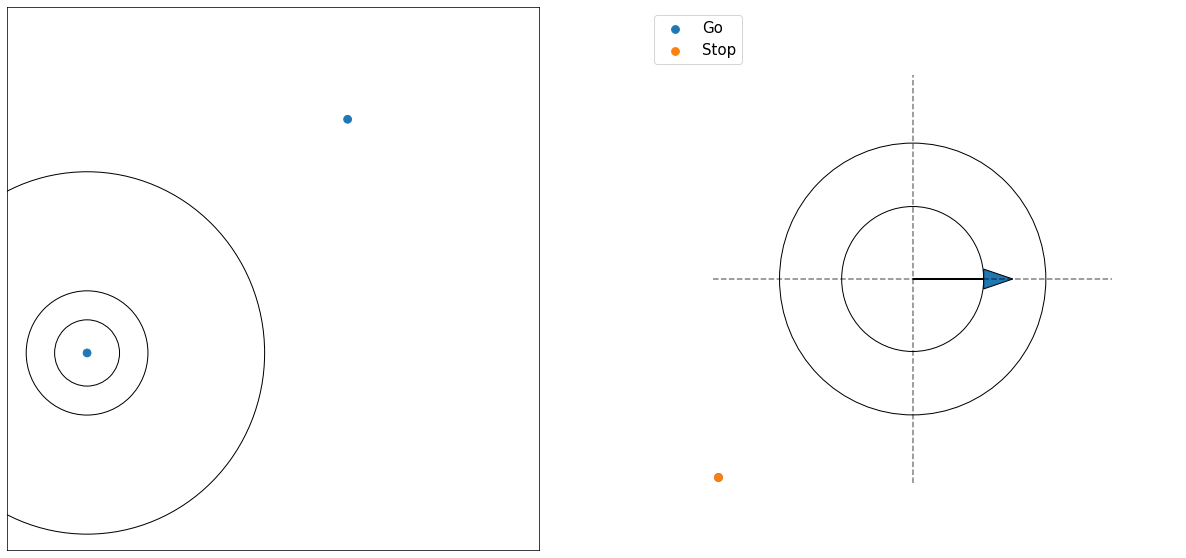

In [22]:
# to make code below easier
numparticles = model.numparticles
xsize, ysize, savestep, dt = model.xsize, model.ysize, model.savestep, model.dt
ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel, ind_stopgo, ind_state = np.arange(9)


wallsegments=np.array([ [[0,0],[xsize,0]], [[xsize,0],[xsize,ysize]], [[xsize,ysize],[0,ysize]], [[0,ysize],[0,0]] ])
showlen=np.floor(100/savestep).astype(int)
cmap = plt.get_cmap('viridis')

clrs = cmap(model.tau_turn)
# clrs= [snscolors[3],snscolors[0]]

    
def f(step):
    focus=0
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches((21,10))

    ax[0].axis('off')

    for k in range(len(wallsegments)):
        ax[0].plot(wallsegments[k,:,0],wallsegments[k,:,1],'k')  
    
    clrs = [snscolors[0] if state==0 else snscolors[1] for state in allparticles[step,:,ind_state]]
    ax[0].scatter(allparticles[step-showlen:step,:,0],allparticles[step-showlen:step,:,1],color='grey',alpha=0.2,s=10)
    ax[0].scatter(allparticles[step,:,0],allparticles[step,:,1],color=clrs,s=60)
    circler = plt.Circle((allparticles[step,focus,0],allparticles[step,focus,1]),model.r_repulsion, color='k', fill=False)
    circlea = plt.Circle((allparticles[step,focus,0],allparticles[step,focus,1]), model.r_align, color='k', fill=False)
    ax[0].add_patch( circler )
    ax[0].add_patch( circlea )
    if model.r_align>0:
        circlea = plt.Circle((allparticles[step,focus,0],allparticles[step,focus,1]), model.r_attract, color='k', fill=False)
        ax[0].add_patch( circlea )    
    
    ax[0].set_xlim([0,xsize])
    ax[0].set_ylim([0,ysize])    
    
    ax[1].axis('off')

    ax[1].scatter(alldcoords_rotated[step-showlen:step,focus,:,0],alldcoords_rotated[step-showlen:step,focus,:,1],color='grey',alpha=0.2,s=10)
    for state in range(2):  # a hack for a legend for stop-go states
        ax[1].scatter(-10,-10,color=snscolors[state],s=60,label=['Go','Stop'][state])
    circler = plt.Circle((0,0) ,model.r_repulsion, color='k', fill=False)
    circlea = plt.Circle((0,0) , model.r_align, color='k', fill=False)
    ax[1].add_patch( circler )
    ax[1].add_patch( circlea )
    if model.r_align>0:
        circlea = plt.Circle((0,0) , model.r_attract, color='k', fill=False)
        ax[1].add_patch( circlea )
    ax[1].arrow(0,0,model.r_repulsion,0,head_width=1)
    ax[1].legend(fontsize=15,loc=2)
    ax[1].plot([0,0],[-model.r_align*1.5,model.r_align*1.5],'k--',alpha=0.5)
    ax[1].plot([-model.r_align*1.5,model.r_align*1.5],[0,0],'k--',alpha=0.5)
    
    ax[1].set_xlim([-2*model.r_align,2*model.r_align])
    ax[1].set_ylim([-2*model.r_align,2*model.r_align])

widgets.interact(f, step=widgets.IntSlider(min=0,max=model.numsavesteps-1,step=3,value=0));  

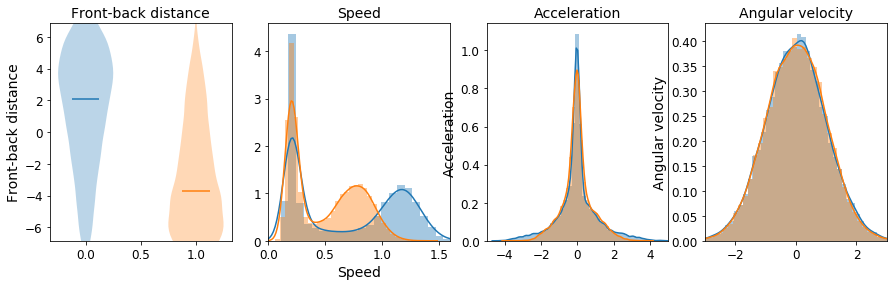

In [23]:
# plots:  front-back dist, speed, ang vel
f, ax = plt.subplots(1,4)
f.set_size_inches(15,4)
# front-back distance
for focus in range(numparticles):
    sel = np.delete(np.arange(numparticles),focus)
    c = alldcoords_rotated[:,focus,sel,0]
    d = alldist[:,focus,sel]
    tp =  - c[d < model.r_attract]  # note the negative sign:  here, plotting which is more of a "leader"
    if len(tp)>0:
        ax[0].violinplot(tp,positions=[focus],showmedians=True,showextrema=False)
    else:
        print('front-back distance:  zero data points')
ax[0].set_ylabel('Front-back distance',fontsize=14)
ax[0].set_title('Front-back distance',fontsize=14)
ax[0].set_ylim([-model.r_align,model.r_align])

# speed
a=ax[1]
[sns.distplot(allparticles[:,focus,ind_spd],ax=ax[1],hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlabel('Speed',fontsize=14)
a.set_title('Speed',fontsize=14)
# a.set_ylim([0,2])
a.set_xlim([0,1.6])

# acceleration
a=ax[2]
[sns.distplot(np.gradient(allparticles[:,focus,ind_spd])/dt,ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_ylabel('Acceleration',fontsize=14)
a.set_title('Acceleration',fontsize=14)
a.set_xlim([-5,5])

# angvel
a=ax[3]
avmax=10
[sns.distplot(allparticles[:,focus,ind_angvel][np.abs(allparticles[:,focus,ind_angvel])<=avmax],ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlim([-3,3])
a.set_ylabel('Angular velocity',fontsize=14)
a.set_title('Angular velocity',fontsize=14)

# format
# [a.set_xticks(np.arange(numparticles)) for a in ax]
# [a.set_xlabel('Fish',fontsize=14) for a in ax]
[a.tick_params(labelsize=12) for a in ax]
plt.show()

## view plots of distributions (2 agents)

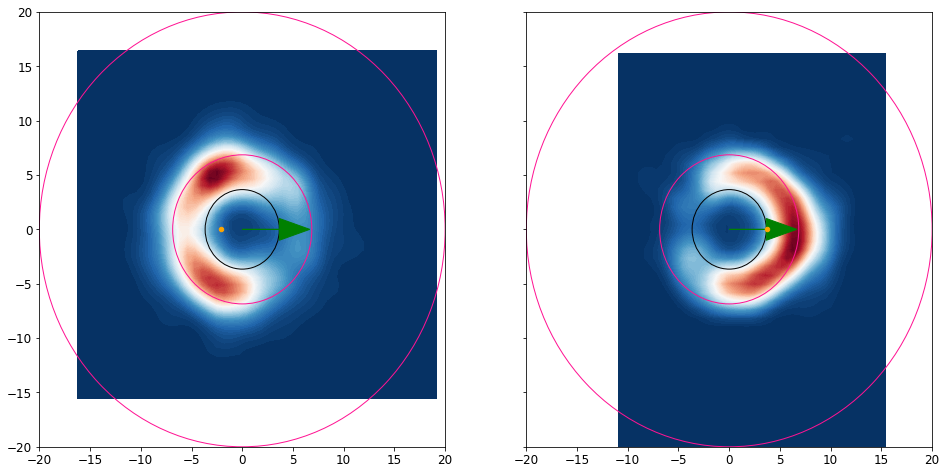

In [24]:

skip=10  # don't use all the points to make the plot, because its too many

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
fig.set_size_inches((16,8))    
for focus in range(2):    
    sel = np.delete(np.arange(numparticles),focus)
    d = alldist[:,focus,sel]
    dsel = (d < model.r_attract)

    # get front-back distance and left-right distance
    temp = alldcoords_rotated[:,focus,sel,0]  #note:  doing this is two steps allows to keep multi-dimensional possibility, if have more neighbors
    fb = temp[dsel]
    temp = alldcoords_rotated[:,focus,sel,1]
    lr = temp[dsel]
    a = ax[focus]    
    numparticles = model.numparticles
    sns.kdeplot(fb[::skip],lr[::skip],shade=True,cmap="RdBu_r", n_levels=100, ax=a, gridsize=50)
    a.arrow(0,0,model.r_repulsion,0,head_width=2,color='green')
    circler = plt.Circle((0,0),model.r_repulsion, color='k', fill=False)
    circlea = plt.Circle((0,0), model.r_align, color='deeppink', fill=False)
    circleaa = plt.Circle((0,0), model.r_attract, color='deeppink', fill=False)
    a.add_patch( circler )
    a.add_patch( circlea )
    if model.r_attract > model.r_align:
        a.add_patch(circleaa)
        showlim = model.r_attract
    else:
        showlim = model.r_align
    a.set_xlim(-showlim,showlim)
    a.set_ylim(-showlim,showlim)
    a.tick_params(labelsize=12)
    a.scatter(np.median(fb),[0],color='orange',zorder=3,s=20)
#     a.axis('off')
# plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

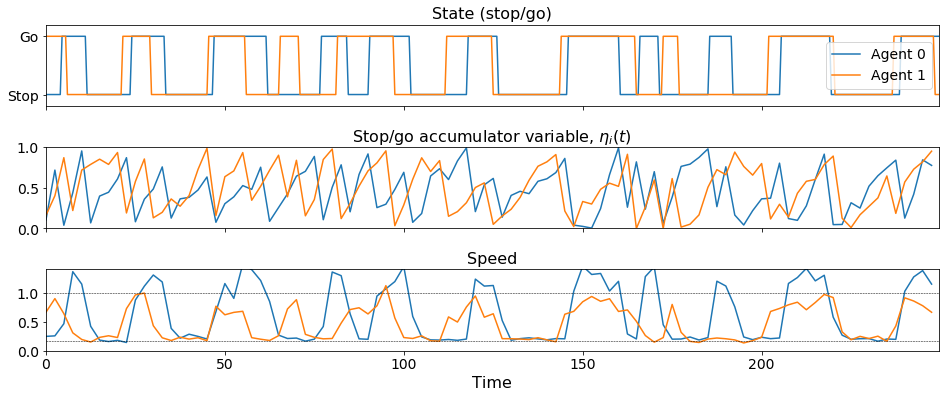

<function __main__.showfromstep(step)>

In [25]:
showlen2=500
tptimes = np.arange(showlen2)*model.dt*model.savestep
def showfromstep(step):
    f, ax = plt.subplots(3,1,sharex=True)
    f.set_size_inches(16,6)

    for j in range(2):
        skip=5
        ax[0].plot(tptimes,1-allparticles[step:step+showlen2,j,ind_state],color=snscolors[j],label='Agent '+str(j))    
        ax[1].plot(tptimes[::skip],allparticles[step:step+showlen2,j,ind_stopgo][::skip],color=snscolors[j],label='Agent '+str(j))
        ax[2].plot(tptimes[::skip],allparticles[step:step+showlen2,j,ind_spd][::skip],color=snscolors[j],label='Agent '+str(j))
        
    # formatting and labels
    a=ax[0]
    a.set_title('State (stop/go)',fontsize=16)
    a.set_yticks([0,1])
    a.set_yticklabels(['Stop','Go'],fontsize=14)
    a.set_ylim([-0.2,1.2])
    a.legend(fontsize=14)
    
    a=ax[1]
    a.set_title('Stop/go accumulator variable, $\eta_i(t)$',fontsize=16)
    a.set_ylim([0,1])
          
    a=ax[2]
    a.set_title('Speed',fontsize=16)
    a.set_ylim([0,1.4])
    a.set_yticks([0,0.5,1])
    [a.axhline(y,c='k',linestyle='--',linewidth=0.5) for y in model.statespeedmult[0]]
    
    ax[0].set_xlim([0,tptimes[-1]])
    ax[-1].set_xlabel('Time',fontsize=16)
    [a.tick_params(labelsize=14) for a in ax]
    plt.subplots_adjust(hspace=0.5)
    
widgets.interact(showfromstep, step=widgets.IntSlider(min=0,max=len(allparticles)-showlen2-1,value=39200,step=10))

# Output or read results to/from file

### Save current simulation results to file

In [100]:
savefile = 'simresults/example.pkl'
pickle.dump([model, allparticles, alldist, alldcoords_rotated],open(savefile,'wb'))

## Stop-go example

### Read simulation results from file

In [36]:
savefile = 'simresults/stopgo-example.pkl'
[model, allparticles, alldist, alldcoords_rotated] = pickle.load(open(savefile,'rb'))

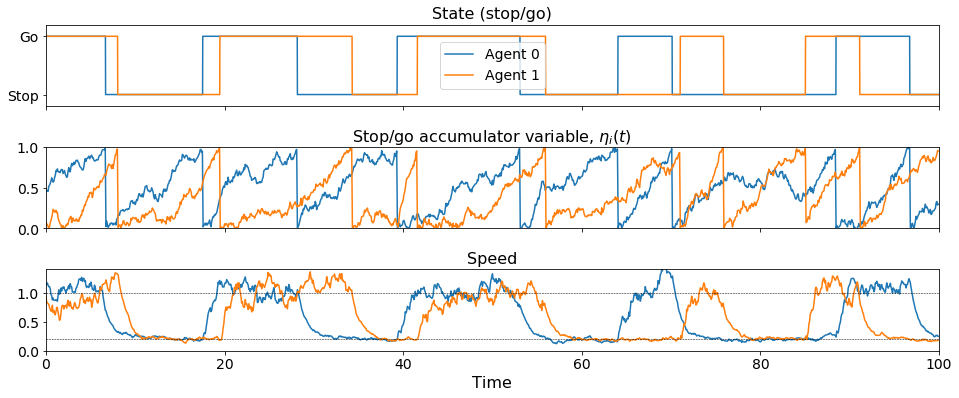

In [104]:
step=39200
showfromstep(step)
plt.savefig('stopgo-example.pdf')

## Output to CSV

In [5]:
# Write to csv
import pandas as pd
savedir = "/Users/jollejolles/Dropbox/Science/4 Projects/P4 Focus/PR023 Schisto movement dynamics/Data/"

focus=0
df0 = pd.DataFrame({'timestep': np.arange(1, 20001, 1),
              'ID': np.array([focus]*len(allparticles)),
              'x': allparticles[:,focus,ind_x], 
              'y': allparticles[:,focus,ind_y],
              'heading': allparticles[:,focus,ind_ang],
              'state': allparticles[:,focus,ind_state]})
focus=1
df1 = pd.DataFrame({'timestep': np.arange(1, 20001, 1),
                    'ID': np.array([1]*len(allparticles)),
              'x': allparticles[:,focus,ind_x], 
              'y': allparticles[:,focus,ind_y],
              'heading': allparticles[:,focus,ind_ang],
              'state': allparticles[:,focus,ind_state]})
df = pd.concat([df0, df1])

df.to_csv(savedir+"vidsim_speeddiff.csv") 
#df.to_csv(savedir+"vidsim_speeddiffstates.csv") 